In [3]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [40]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=40

## Loading the dataset

In [5]:
import zipfile
zip_ref= zipfile.ZipFile("/content/Potato.zip",'r')
zip_ref.extractall('/content')
zip_ref.close()

In [6]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/Potato",
    seed=13,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)


Found 5403 files belonging to 3 classes.


In [7]:
class_names= dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [8]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[0 0 0 1 1 2 1 1 0 0 0 0 0 0 2 1 1 1 1 2 2 1 1 1 1 0 0 0 0 1 2 0]


## Visualizing

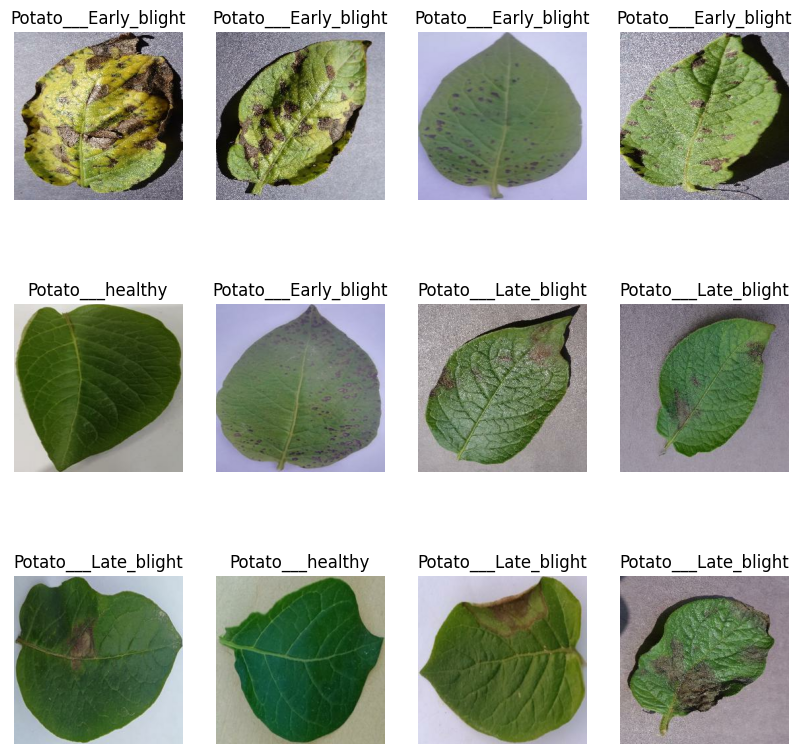

In [9]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

## train test split

In [10]:
len(dataset)

169

In [11]:
train_size= 0.8
train_ds= dataset.take(int(len(dataset)*train_size))
len(train_ds)

135

In [12]:
test_ds= dataset.skip(135)
len(test_ds)

34

In [13]:
val_size=0.1
len(dataset)*val_size

16.900000000000002

In [14]:
val_ds = test_ds.take(16)
len(val_ds)

16

In [15]:
test_ds = test_ds.skip(16)
len(test_ds)

18

In [16]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [17]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

## Cache, shuffle, prefetch

In [18]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [19]:
import tensorflow as tf
from tensorflow.keras import layers
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.Rescaling(1./255),
])

## Data augmentation using ImageDataGenerator

In [20]:
import tensorflow as tf
from tensorflow.keras import layers

# Define the resizing and rescaling layers using the updated API
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),  # Resize images to the target size
    layers.Rescaling(1./255)  # Rescale pixel values to the range [0, 1]
])


In [21]:
import tensorflow as tf
from tensorflow.keras import layers

# Define the data augmentation layer using the updated API
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),  # Flip images horizontally and vertically
    layers.RandomRotation(0.2)  # Randomly rotate images by 20%
])


In [22]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [23]:
import tensorflow as tf
from tensorflow.keras import layers, models
n_classes=3
# Define the model using Sequential API
from tensorflow.keras import layers, models

model = models.Sequential([
    # Initial Convolutional Block
    layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),  # Input layer
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Second Convolutional Block
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Third Convolutional Block
    layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Fourth Convolutional Block
    layers.Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Fifth Convolutional Block
    layers.Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Global Average Pooling Layer
    layers.GlobalAveragePooling2D(),

    # Dense Layers
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),  # Dropout to reduce overfitting
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),

    # Output Layer
    layers.Dense(n_classes, activation='softmax')
])


In [24]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 256, 256, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 batch_normalization_1 (Bat  (None, 128, 128, 64)      256       
 chNormalization)                                                
                                                      

In [25]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [26]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=40,
)

Epoch 1/40
135/135 [==============================] - 136s 990ms/step - loss: 0.7243 - accuracy: 0.6962 - val_loss: 3.6627 - val_accuracy: 0.4648
Epoch 2/40
135/135 [==============================] - 132s 974ms/step - loss: 0.5165 - accuracy: 0.8056 - val_loss: 1.0523 - val_accuracy: 0.7090
Epoch 3/40
135/135 [==============================] - 130s 958ms/step - loss: 0.4560 - accuracy: 0.8336 - val_loss: 0.8056 - val_accuracy: 0.7383
Epoch 4/40
135/135 [==============================] - 130s 958ms/step - loss: 0.3496 - accuracy: 0.8781 - val_loss: 0.6663 - val_accuracy: 0.7383
Epoch 5/40
135/135 [==============================] - 131s 967ms/step - loss: 0.3060 - accuracy: 0.8911 - val_loss: 1.2289 - val_accuracy: 0.6445
Epoch 6/40
135/135 [==============================] - 130s 961ms/step - loss: 0.2646 - accuracy: 0.9050 - val_loss: 0.3246 - val_accuracy: 0.8965
Epoch 7/40
135/135 [==============================] - 129s 957ms/step - loss: 0.2171 - accuracy: 0.9261 - val_loss: 0.3706 -

In [27]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0


In [28]:
scores = model.evaluate(test_ds)

18/18 [==============================] - 4s 194ms/step - loss: 0.0948 - accuracy: 0.9688


In [29]:
scores

[0.0948484018445015, 0.96875]

In [30]:
history

In [31]:
history.params

{'verbose': 1, 'epochs': 40, 'steps': 135}

In [32]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [33]:
type(history.history['loss'])

list

In [34]:
len(history.history['loss'])

40

In [35]:
# Accessing the accuracy after the final epoch
training_accuracy = history.history['accuracy'][-1]
validation_accuracy = history.history['val_accuracy'][-1]


print(f"Final Training Accuracy: {training_accuracy * 100:.2f}%")
print(f"Final Validation Accuracy: {validation_accuracy * 100:.2f}%")


Final Training Accuracy: 98.79%
Final Validation Accuracy: 93.16%


In [36]:
history.history['loss'][:5]

[0.7242729067802429,
 0.516531765460968,
 0.45599842071533203,
 0.34962669014930725,
 0.3059750199317932]

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

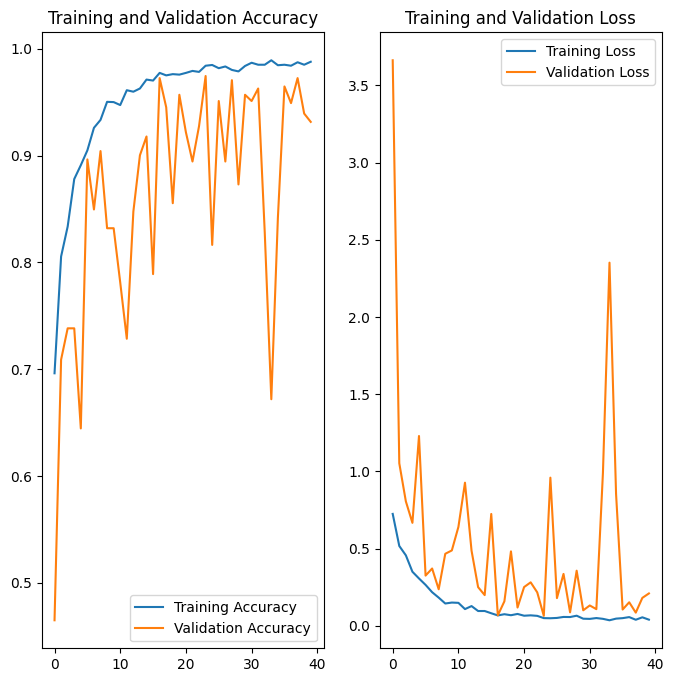

In [41]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Potato___healthy
1/1 [==============================] - 0s 384ms/step
predicted label: Potato___healthy


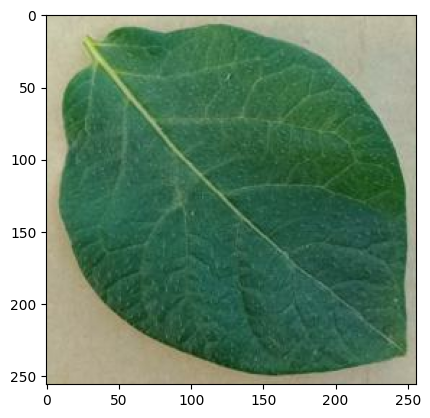

In [42]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [43]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(3):
    for i in range(15):
        ax = plt.subplot(6, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

1/1 [==============================] - 0s 35ms/step


In [45]:
# import os
# model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
# model.save(f"../models/{model_version}")

In [46]:
# import pickle
# import tensorflow as tf
# from tensorflow.keras import models

# # Assuming 'model' is your trained model
# # Save model architecture
# model_json = model.to_json()

# # Save the model architecture and weights separately
# with open("model_architecture.json", "w") as json_file:
#     json_file.write(model_json)

In [47]:
import pickle
import tensorflow as tf

# Assuming `model` is your trained model
# Save model architecture and weights
model_json = model.to_json()  # Save the architecture
model_weights = model.get_weights()  # Save the weights

# Save to a pickle file
with open("potato_disease.pkl", "wb") as f:
    pickle.dump({
        "architecture": model_json,
        "weights": model_weights
    }, f)


